# Chapter 3: Classification

In [112]:
import numpy as np
import pandas as pd
import matplotlib

## MNIST Classification

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- `DESCR` describes the dataset
- `data` array with one row few instance and one column per feature
- `target` array with labels

In [5]:
input_array, output_array = mnist["data"], mnist["target"]

In [6]:
input_array.shape

(70000, 784)

In [7]:
output_array.shape

(70000,)

- 784 features(28 * 28 pixels)
- Intensity if from 0 (white) to 255 (black)

# Visualizing the Numbers

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
example_num = input_array[42]

In [10]:
example_num_image = example_num.reshape(28, 28)

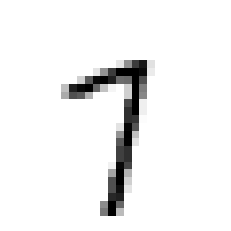

In [11]:
plt.imshow(example_num_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
output_array[42]

'7'

- Change the labels to numerical data

In [13]:
output_array = output_array.astype(np.uint8)

# Split the Data

- Data is already shuffled 

In [14]:
X_train, X_test, y_train, y_test = input_array[:60000], input_array[60000:], output_array[:60000], output_array[60000:]

# Training a Binary Classifier

- Creating an identifier that will predict if an image is `8` or not

- Target vectors the classification class

In [15]:
y_train_8 = (y_train == 8)

In [16]:
y_test_8 = (y_test == 8)

In [17]:
y_train_8

array([False, False, False, ..., False, False,  True])

In [18]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

- Starting off with Stochastic Gradient Descent
    - Can handle very large datasets efficiently
    - Deals with training instances independently, one at a time(makes it good for online learning)

In [19]:
from sklearn.linear_model import SGDClassifier

In [20]:
sgd_clf = SGDClassifier(random_state=42)

In [21]:
sgd_clf.fit(X_train[:1000], y_train_8[:1000])

SGDClassifier(random_state=42)

# Performance Measures

## Measuring Accuracy Using Cross Validation

## My own Cross Validation

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

- Stratified Sampling to produce folds that contain representative ratio of each class

In [23]:
skfolds = StratifiedKFold(n_splits=3)

## K-Fold Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score(sgd_clf, X_train[:1000], y_train_8[:1000], cv=3, scoring="accuracy")

array([0.93113772, 0.91591592, 0.94594595])

## Check with Dummy Classifier

In [26]:
from sklearn.base import BaseEstimator

In [27]:
class Never8Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [28]:
never_8_clf = Never8Classifier()

In [29]:
cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.9039 , 0.9031 , 0.90045])

## Confusion Matrix

In [30]:
from sklearn.model_selection import cross_val_predict

- K-fold cross validation that makes a prediction for each test fold(that wasn't seen during training)

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_train_8[:1000], y_train_pred[:1000])

array([[850,  63],
       [ 22,  65]])

                Predicted Negative Predicted Positive
Actual Negative True Negative False Positive
Actual Positive False Negative True Positive

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [35]:
precision_score(y_train_8[:1000], y_train_pred[:1000])

0.5078125

In [36]:
recall_score(y_train_8[:1000], y_train_pred[:1000])

0.7471264367816092

In [37]:
f1_score(y_train_8[:1000], y_train_pred[:1000])

0.6046511627906975

- You can increase precision or recall at the cost of the other. Depends on where you put the threshold to predict a positive case

# Changing the Threshold 

https://stackoverflow.com/questions/20113206/scikit-learn-svc-decision-function-and-predict

In [38]:
y_scores = sgd_clf.decision_function(X_train)

In [39]:
y_scores

array([-3114154.31866916, -2494273.3459625 , -1530705.2101543 , ...,
       -1010782.52911331, -3277065.85309683,  1376328.61993912])

In [40]:
threshold = 0

In [41]:
y_some_digit_pred = (y_scores > threshold)

In [42]:
y_some_digit_pred

array([False, False, False, ..., False, False,  True])

In [43]:
np.sum(y_some_digit_pred)

5604

# New Threshold

In [44]:
threshold = 20000

In [45]:
y_some_digit_pred = (y_scores > threshold)

In [46]:
y_some_digit_pred

array([False, False, False, ..., False, False,  True])

In [47]:
np.sum(y_some_digit_pred)

5483

- So raising the threshold decreases the the recall. Because none were predicted as being True

## Determining the Threshold to Use

- We need to get the decison scores from the model instead of the actual predictions

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train[:1000], y_train_8[:1000], cv=3, method="decision_function")

In [49]:
from sklearn.metrics import precision_recall_curve

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train_8[:1000], y_scores[:1000])

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

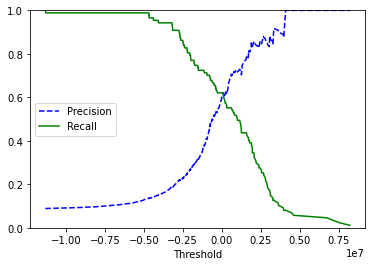

In [52]:
plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)
plt.show()

# Plotting Precision against Recall

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
#     plt.ylim([0,1])

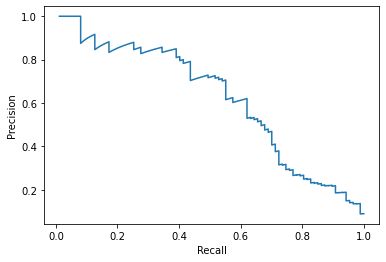

In [54]:
plot_precision_vs_recall(precisions=precisions, recalls=recalls)

# Changing the threshold to get an acceptable Precision or Recall

- Example, we want a model with 90% percision.
- We would go to the threshold curve, and find the threshold where percision is 90. And use that threshold in the model.

In [55]:
y_train_pred_90 = (y_scores > 5000)

In [56]:
precision_score(y_train_8[:1000], y_train_pred_90[:1000])


0.6067415730337079

In [57]:
recall_score(y_train_8[:1000], y_train_pred_90[:1000])


0.6206896551724138

# ROC Curve

- ROC Curve: Reciever Operating Characteristic Curve
    - Often used in Binary classification
    - Plots the True Positive Rate againest the False Positive Rate
    - True Positive Rate: Recall or TP / (TP + FN)
    - False Positive Rate: FP / (FP + TN) 
        - FPR: Ratio of negative instances that are inorrectly classified as positive. 1 - True negative rate. (TNR: negatives instances that are correctly classified as negative. The specificity). 
    - AKA plots sensitivity(recall) against 1 - specificity

In [58]:
from sklearn.metrics import roc_curve

In [59]:
fpr, tpr, thresholds = roc_curve(y_train_8[:1000], y_scores[:1000])

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

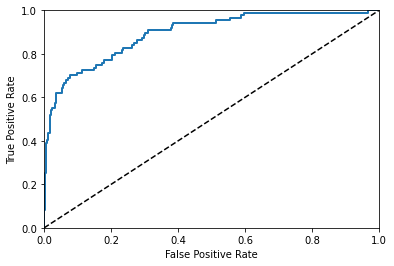

In [61]:
plot_roc_curve(fpr, tpr)
plt.show()

- The higher the recall(TPR), the more false positive are identified. 
- The dotted line is the ROC curve of a purely random classifier. The goal is to stay as far away as you can from the dotted line. 
- You can measure the area under the curve. 

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_train_8[:1000], y_scores[:1000])

0.893139957950926

- Use the Precision Recall curve when the positive class is rare or when you care more about the false positives than the false negatives.
- Use the ROC curve for other instances.

In [64]:
from sklearn.ensemble import RandomForestClassifier

- `RandomForestClassifier` does not have a `decision_function()` but instead has a `predict_proba()` method.
- Sklearn classifiers usually have one or the other
- `predict_proba()` returns an array containing a row per instance and a column per class, each containing the probability that a given instance belongs to the class

In [65]:
forest_clf = RandomForestClassifier(random_state=42)

In [66]:
y_probas_forest = cross_val_predict(forest_clf, X_train[:1000], y_train_8[:1000], cv=3,\
                                    method="predict_proba")

- Because you need scored for a ROC curve(not probabilities), we can use the positive class's probability as a score

In [67]:
y_probas_forest

array([[0.96, 0.04],
       [1.  , 0.  ],
       [0.98, 0.02],
       ...,
       [0.94, 0.06],
       [0.9 , 0.1 ],
       [0.94, 0.06]])

In [68]:
# Probability of a positive class
y_scores_forest = y_probas_forest[:, 1]

In [69]:
y_scores_forest

array([0.04, 0.  , 0.02, 0.  , 0.02, 0.06, 0.05, 0.05, 0.02, 0.05, 0.04,
       0.1 , 0.12, 0.03, 0.04, 0.  , 0.04, 0.64, 0.03, 0.04, 0.12, 0.02,
       0.03, 0.01, 0.02, 0.33, 0.  , 0.09, 0.13, 0.02, 0.05, 0.59, 0.  ,
       0.07, 0.24, 0.03, 0.11, 0.04, 0.03, 0.05, 0.01, 0.46, 0.  , 0.04,
       0.09, 0.  , 0.29, 0.09, 0.07, 0.05, 0.03, 0.08, 0.01, 0.03, 0.06,
       0.33, 0.09, 0.02, 0.11, 0.01, 0.06, 0.02, 0.12, 0.12, 0.06, 0.2 ,
       0.14, 0.04, 0.09, 0.11, 0.05, 0.  , 0.02, 0.06, 0.02, 0.05, 0.22,
       0.02, 0.04, 0.02, 0.14, 0.08, 0.05, 0.18, 0.  , 0.49, 0.16, 0.04,
       0.05, 0.02, 0.  , 0.  , 0.  , 0.12, 0.35, 0.06, 0.  , 0.6 , 0.04,
       0.  , 0.1 , 0.01, 0.02, 0.  , 0.01, 0.08, 0.06, 0.04, 0.1 , 0.08,
       0.06, 0.13, 0.  , 0.03, 0.03, 0.03, 0.  , 0.19, 0.11, 0.05, 0.07,
       0.12, 0.05, 0.01, 0.02, 0.38, 0.04, 0.05, 0.04, 0.14, 0.03, 0.04,
       0.04, 0.01, 0.1 , 0.03, 0.16, 0.41, 0.07, 0.02, 0.01, 0.06, 0.05,
       0.09, 0.25, 0.09, 0.57, 0.04, 0.02, 0.06, 0.

In [70]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8[:1000], y_scores_forest[:1000])

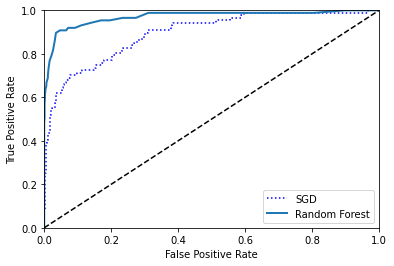

In [71]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [72]:
roc_auc_score(y_train_8[:1000], y_scores_forest[:1000])

0.9702446148229281

# Multiclass Classification

- Some classifiers can handle multiclasses directly
    - Like Random Forest of Naaive Bayes
- Others are strictly Binary
    - Like Suppoert Vector Machines or Linear classifiers
- But there are ways to perform multiclass classification with Binary classifiers

- One Verse All Strategy(OVA)
    - Make a binary classifier for each digit, then classify the image with the highest score
    - Preferred for most binary classification
- One versus one
    - Making a binary classifier for each pair of digits
    - This would require N * (N - 1) / 2 Classifiers
    - Advantage is that each classifier needs to be only trained on part of the training set for the two classes its trying to distinguish
    - Preferred for larger datasets because it's faster to train on the smaller sets
    

- Scikit learn will automatically switch to OvA if you use a binary classification task for a multi class classification task
    - (unless if you're using Support Vector Machine then it'll switch to OvO)

In [73]:
X_train[:1000].shape

(1000, 784)

In [74]:
sgd_clf.fit(X_train[:100], y_train[:100])

SGDClassifier(random_state=42)

In [75]:
sgd_clf.predict([X_train[999]])

array([5], dtype=uint8)

In [76]:
scores_101 = sgd_clf.decision_function([X_train[101]])

In [77]:
np.argmax(scores_101)

7

In [78]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [79]:
sgd_clf.classes_[7]

7

# OneVsOneClassifier or OneVsRestClassifier

- You can force sklearn to use one verse all or one verse all. 
- Just create an instance and pass the binary classifier to the constructor


- Example: Multiclass classifier using One Vs All strategy with RandomForest classifier

In [80]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [81]:
# Passing the Binary classifier to the constructor
ova_svm = OneVsRestClassifier(estimator=svm.SVC())

In [82]:
ova_svm.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC())

In [83]:
ova_svm.predict([X_train[999]])

array([6], dtype=uint8)

# Random Forest 

- You don't need to run OvO or OvA with Random forest because it can already classify multiple classes

In [84]:
forest_clf.fit(X_train[:1000], y_train[:1000])

RandomForestClassifier(random_state=42)

In [85]:
forest_clf.predict([X_train[1001]])

array([7], dtype=uint8)

In [86]:
# List of probabilities that the classifer assigned to each instance of the class
forest_clf.predict_proba([X_train[1001]])

array([[0.  , 0.01, 0.02, 0.05, 0.13, 0.07, 0.02, 0.49, 0.06, 0.15]])

In [87]:
X_train.shape

(60000, 784)

## Cross Validation

In [88]:
cross_val_score(sgd_clf, X_train[:10000], y_train[:10000], cv=3, scoring="accuracy")

array([0.86592681, 0.86978698, 0.85448545])

## Scaling

- Scaling the inputs can increase the accuracy

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()

In [91]:
X_train_scaled = scaler.fit_transform(X=X_train.astype(np.float64))

In [92]:
cross_val_score(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

- To improve a model, look over the errors that it makes

- First place to look is the confusion matrix

In [93]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [94]:
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])

In [95]:
conf_mx

array([[ 96,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0, 110,   1,   1,   0,   1,   0,   0,   3,   0],
       [  1,   2,  83,   2,   2,   2,   1,   1,   5,   0],
       [  0,   0,   2,  80,   0,   3,   0,   2,   3,   3],
       [  0,   0,   1,   0,  97,   0,   1,   0,   4,   2],
       [  0,   0,   0,   8,   2,  68,   1,   0,  10,   3],
       [  1,   0,   0,   1,   1,   0,  87,   1,   3,   0],
       [  0,   0,   1,   0,   2,   0,   0, 107,   3,   4],
       [  0,   1,   0,   1,   0,   2,   0,   0,  83,   0],
       [  1,   0,   1,   0,   5,   1,   0,   5,   6,  81]])

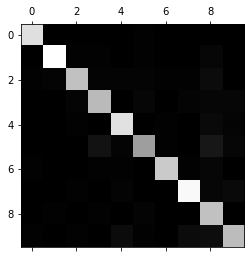

In [96]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

- The above only looks at absolute number of errors which may not reflect the actual rates.
- So divide each value in the confusion matrix by the number of images in the corresponding class.

In [97]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [98]:
norm_conf_mx = conf_mx / row_sums

- Filling the diagonal with zeros to keep only the errors

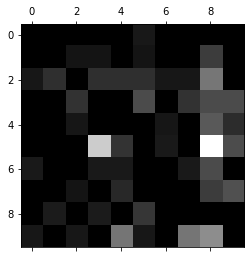

In [99]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [100]:
norm_conf_mx

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01030928, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00862069, 0.00862069, 0.        ,
        0.00862069, 0.        , 0.        , 0.02586207, 0.        ],
       [0.01010101, 0.02020202, 0.        , 0.02020202, 0.02020202,
        0.02020202, 0.01010101, 0.01010101, 0.05050505, 0.        ],
       [0.        , 0.        , 0.02150538, 0.        , 0.        ,
        0.03225806, 0.        , 0.02150538, 0.03225806, 0.03225806],
       [0.        , 0.        , 0.00952381, 0.        , 0.        ,
        0.        , 0.00952381, 0.        , 0.03809524, 0.01904762],
       [0.        , 0.        , 0.        , 0.08695652, 0.02173913,
        0.        , 0.01086957, 0.        , 0.10869565, 0.0326087 ],
       [0.0106383 , 0.        , 0.        , 0.0106383 , 0.0106383 ,
        0.        , 0.        , 0.0106383 , 0.03191489, 0.        ],
       [0.        , 0.        , 0.0085470

- Rows are actual classes, and columns are predicted classes
- Darker is more wrong, and lighter is right

- This gives you an idea of where to focus your efforts. 
- Like focusing on 8 because it is often misclassified. You could get more data, or engineer more features, or preprocess images. 

- You can also look at individual errors, but it is time consuming

In [101]:
cl_a, cl_b = 3, 5

In [102]:
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 

In [106]:
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [110]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

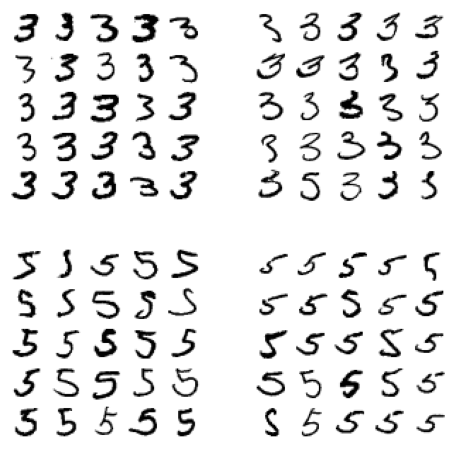

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# Left side, classified as 3 # Right side, classified as 5

- We can preprocess images so that they are well centered and not rotated too much

# Multilabel Classification

Currently on page: 100